In [20]:
import os, gc, glob, numpy as np, pandas as pd, regex as re, time, \
    warnings, numba as nb, joblib as jl, json, seaborn as sns, scipy.stats, \
    matplotlib.colors as mplcol
import matplotlib.pyplot as plt, matplotlib as mpl
import skimage.transform, skimage.segmentation
from tqdm import tqdm_notebook as tqdm
from plotnine import *
from scipy.cluster import hierarchy
from scipy.stats import variation
import warnings; warnings.filterwarnings("ignore")

In [38]:
# Load polarpos data, and accompanying HHMM predictions
#fnames = glob.glob('Y:/wavelet/hhmm-results/*regimes_12minrun_manuallabels_5fold.*.resave.pickle')
fnames = glob.glob('Y:/wavelet/hhmm-results/*regimes_12minrun_manuallabels_5fold.pickle')
fnames = [x for x in fnames if not 'idxmapping' in x]
fnames = [fnames[5],]
fnames

['Y:/wavelet/hhmm-results\\5regimes_12minrun_manuallabels_5fold.pickle']

In [39]:
t0 = time.time()

gc.collect()

def loadPickle(fn):
    try:
        gc.disable()
        return jl.load(fn)
        gc.enable()
    except Exception as e:
        print(fn, str(e))
        return None
    
data = [loadPickle(fn) for fn in tqdm(fnames)]
data = [x for x in data if x is not None]

t1 = time.time()

In [40]:
def loadData(modelIdx, modelRepIdx, modelRecIdx):
    def loadJSON(x):
        if os.path.exists(x):
            with open(x, 'r') as f:
                return json.load(f)
        else:
            return None

    # Load position/orientation data
    fnamePos = glob.glob(os.path.abspath(os.path.join(os.path.dirname(
        data[modelIdx]['fnames'][modelRecIdx][0]), '../croprot/*dlc_position_orientation.npy')))[0]

    # Load recording info
    fnameRecInfo = os.path.join(os.path.dirname(os.path.dirname(fnamePos)), 'recording.json')
    recordingInfo = loadJSON(fnameRecInfo)

    # Create short name
    fnamesShort = re.search('^Z:/.*/(.*)/.*/.*$', fnamePos.replace('\\', '/')).group(1)

    # Fill in missing stage information, if necessary
    s = recordingInfo
    s['fname'] = fnamePos

    # Does this recording.json file specify stage ranges, or starting points?
    if isinstance(s['stages']['protoweb'], list):
        for st in s['stages']:
            try:
                if not isinstance(s['stages'][st][0], list):
                    s['stages'][st] = [s['stages'][st], ]
            except:
                s['stages'][st] = []
    else:
        # Add the end of the recording
        a = np.load(s['fname'], mmap_mode='r')
        s['stages']['end'] = a.shape[0]

        if 'stabilimentum' in s['stages']:
            if s['stages']['stabilimentum'] >= 0:
                pass
            else:
                s['stages']['stabilimentum'] = s['stages']['end']
        else:
            s['stages']['stabilimentum'] = s['stages']['end']

        # Now convert to ranges
        s['stages']['protoweb'] = [[s['stages']['protoweb'], s['stages']['radii']],]
        s['stages']['radii'] = [[s['stages']['radii'], s['stages']['spiral_aux']],]
        s['stages']['spiral_aux'] = [[s['stages']['spiral_aux'], s['stages']['spiral_cap']],]
        s['stages']['spiral_cap'] = [[s['stages']['spiral_cap'], s['stages']['stabilimentum']],]
        s['stages']['stabilimentum'] = [[s['stages']['stabilimentum'], s['stages']['end']],]
        del s['stages']['end']

    # Convert to indices used in analysis
    arrIdx = np.load(fnamePos.replace('_position_orientation.npy','_abs_filt_interp_mvmt_noborder.idx.npy'))
    for st in s['stages']:
        for k in range(len(s['stages'][st])):
            for m in range(2):
                s['stages'][st][k][m] = np.argmin(np.abs(np.argwhere(arrIdx).T[0] - s['stages'][st][k][m]))
    
    # Load original data
    arr = np.load(fnamePos)

    # Subset by index
    arrIdx = np.load(fnamePos.replace('_position_orientation.npy',
                                      '_abs_filt_interp_mvmt_noborder.idx.npy'))
    arr = arr[arrIdx,:]
    
    # Mapping data
    arrIdxMapping = jl.load(fnames[modelIdx].replace(re.search('([.0-9]*\\.pickle)$', 
        fnames[modelIdx]).group(0), '.idxmapping.pickle').replace('.resave', '').replace('.1', ''))
    
    # Re-duplicate states
    states = data[modelIdx]['models'][modelRepIdx]['model-fit-states'][modelRecIdx]
    statesMapped = np.array([(-1 if x == -1 else states[x]) for x in arrIdxMapping[modelRecIdx]], dtype=int)
    
    # Split states by stage of web-building
    statesMappedByStage = {}
    for st in recordingInfo['stages']:
        idxStage = np.full(statesMapped.shape[0], False, dtype=np.bool)
        for k in recordingInfo['stages'][st]:
            idxStage[k[0]:k[1]] = True
        statesMappedByStage[st] = statesMapped[idxStage]
    
    # Done
    return statesMappedByStage, data[modelIdx]['clusterLabelsUniqueUnified']

In [41]:
allData = [loadData(0, 0, i) for i in tqdm(range(21))]

In [42]:
lbls = allData[0][1]
def remapCluster(x):
    return x
    if 'bend-abdomen' in x:
        return 'bend-abdomen'
    elif 'extrude-slow' in x:
        return 'extrude-slow'
    elif 'extrude' in x:
        return 'extrude'
    elif 'stabilimentum' in x:
        return '' # Don't show stabilimentum
    else:
        return x
idxRemapping = {lbls.index(x):(lbls.index(remapCluster(x)) if len(remapCluster(x))>0 else -1) for x in lbls}

In [105]:
labels = allData[0][1].copy()

transitions = []

mtxTransByStage = {}
for st in allData[0][0]:
    for recid, d in enumerate(allData):
        mtxTrans = np.zeros((len(labels), len(labels)), dtype=np.float64)
        # Map states to merged states
        clMerged = [x for x in d[0][st]]
        #clMerged = [(idxRemapping[x] if x >= 0 else x) for x in d[0][st]]
        ss = -1
        for s in clMerged:
            if s >= 0:
                if s != ss and ss >= 0:
                    mtxTrans[ss, s] += 1
                    transitions.append((st, recid, ss, s))
                ss = s
        mtxTrans = mtxTrans / np.sum(mtxTrans, axis=1)[:,np.newaxis]
        #mtxTrans[np.isnan(mtxTrans)] = 0
        if st not in mtxTransByStage:
            mtxTransByStage[st] = [mtxTrans,]
        else:
            mtxTransByStage[st].append(mtxTrans)
    # Average transition matrices
    mtxTransByStage[st] = np.nanmean(mtxTransByStage[st], axis=0)
    mtxTransByStage[st][np.isnan(mtxTransByStage[st])] = 0

In [106]:
transitions = pd.DataFrame(transitions, columns=['stage', 'recid', 's0', 's1'])
transitions.head()

,stage,recid,s0,s1
0,protoweb,0,41,43
1,protoweb,0,43,11
2,protoweb,0,11,10
3,protoweb,0,10,11
4,protoweb,0,11,43


In [107]:
states = list(set(transitions.s0.unique().tolist() + transitions.s0.unique().tolist()))

In [108]:
stages = ['protoweb', 'radii', 'spiral_aux', 'spiral_cap'] # , 'stabilimentum'
stages

['protoweb', 'radii', 'spiral_aux', 'spiral_cap']

In [110]:
from statsmodels.stats.multitest import multipletests

In [111]:
mtxTransAll = np.sum([x for x in mtxTransByStage.values()], axis=0)

# Determine what states are used
thresh = (mtxTransAll.max() * 0.1).astype(int)

probS0s = []
for ist, st in list(enumerate(stages)):
    # ...
    tmp = transitions[transitions.stage==st].groupby(['recid', 's0']).agg({'s1': 'count'}).reset_index()
    tmp = tmp.groupby('s0').agg({'s1': 'median'}).reset_index()
    probS0 = [y[0] if y.size>0 else 0 for y in [tmp.s1[
        tmp.s0 == x].values.astype(int) for x in np.array(states)]]
    probS0 = np.array(probS0, dtype=float) / np.sum(probS0)
    probS0s.append(probS0)
usedStatesFreq = np.array(states)[np.max(probS0s, axis=0) >= 0.05]

usedStates = np.intersect1d(
    np.argwhere((np.sum(mtxTransAll, axis=0) > thresh)|(np.sum(mtxTransAll, axis=1) > thresh))[:,0],
    usedStatesFreq)

# Now subset everything to these states
for st in mtxTransByStage:
    mtxTransByStage[st] = mtxTransByStage[st][usedStates, :][:, usedStates]

# Subset statistics
try:
    statistics = statistics[usedStates, :][:, usedStates]
except:
    pass
    
# Subset label array
labels = np.array(labels)[usedStates].tolist()
print(len(labels))

# Recompute total transitions
mtxTransAll = np.sum([x for x in mtxTransByStage.values()], axis=0)

12


In [115]:
# Resort everything (within each posterior group)
POSTERIOR = ['extrude-slow', 'extrude', 'none'] # 'bend-abdomen'
tmp = np.hstack((mtxTransAll, mtxTransAll.T)) + \
    np.array([POSTERIOR.index(([x for x in POSTERIOR if x in y] + ['none',])[0]) \
        for y in labels])[:,np.newaxis] * 1000

sort = hierarchy.leaves_list(hierarchy.ward(tmp))

labels = np.array(labels)[sort].tolist()

for st in mtxTransByStage:
    mtxTransByStage[st] = mtxTransByStage[st][sort, :][:, sort]
    
# Resort statistics
try:
    statistics = statistics[sort, :][:, sort]
except:
    pass
    
# Recompute total transitions
mtxTransAll = np.sum([x for x in mtxTransByStage.values()], axis=0)

In [179]:
import colorcet
import matplotlib.colors
import matplotlib.cm as cm

class customColormap(matplotlib.colors.LinearSegmentedColormap):
    def __init__(self, *args, **kwargs):
        self.baseCM = cm.get_cmap('cet_CET_L19')
        self.N = self.baseCM.N
    def __call__(self, r, *args, **kwargs):
        def mapColor(x):
            _c = self.baseCM(0.0, *args, **kwargs)
            return self.baseCM(0.2 + 0.8 * x, *args, **kwargs)
        if np.isscalar(r):
            _c = self.baseCM(0.0, *args, **kwargs)
            cs = np.array([mapColor(r),], 
                dtype=np.float64 if isinstance(_c[0], float) else np.uint8)
            return cs
        if r.ndim == 2:
            _c = self.baseCM(0.0, *args, **kwargs)
            cs = np.array([[mapColor(y) for y in x] for x in r], 
                dtype=np.float64 if isinstance(_c[0], float) else np.uint8)
            return cs
        elif r.ndim == 1:
            _c = self.baseCM(0.0, *args, **kwargs)
            cs = np.array([mapColor(y) for y in r], 
                dtype=np.float64 if isinstance(_c[0], float) else np.uint8)
            return cs
        else:
            print('!!')

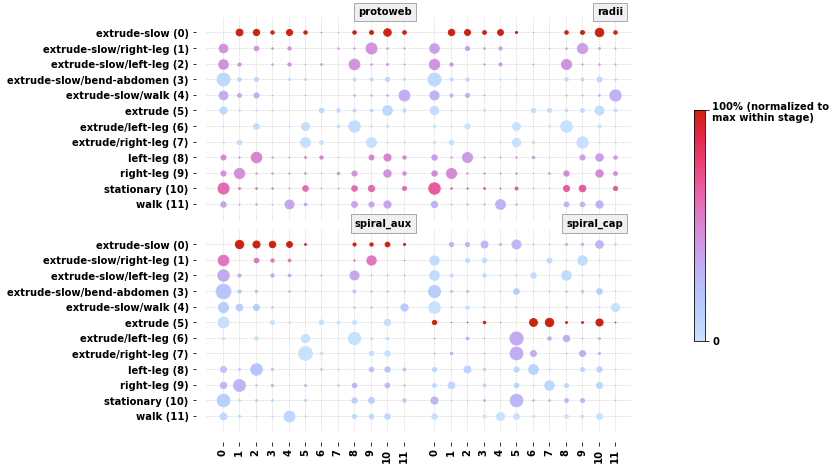

In [182]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8), facecolor='none')
fig.subplots_adjust(hspace=-0.05, wspace=-0.1)

_cm = customColormap()
els = []
for ist, st in list(enumerate(stages)):
    _ax = ax[int(ist / 2)][ist % 2]
    # ...
    tmp = transitions[transitions.stage==st].groupby(['recid', 's0']).agg({'s1': 'count'}).reset_index()
    tmp = tmp.groupby('s0').agg({'s1': 'median'}).reset_index()
    probS0 = [y[0] if y.size>0 else 0 for y in [tmp.s1[
        tmp.s0 == x].values.astype(int) for x in usedStates[sort]]]
    probS0 = np.array(probS0, dtype=float) / np.sum(probS0)
    
    for i in range(mtxTransByStage[st].shape[0]):
        for j in range(mtxTransByStage[st].shape[1]):
            if mtxTransByStage[st][i, j] >= 0:
                v = probS0[i] / np.max(probS0)
                els.append(_ax.scatter(j, mtxTransByStage[st].shape[0]-1-i, s=mtxTransByStage[st][i, j] * 250, 
                    color=_cm(v)))
    
    w = mtxTransByStage[st].shape[0]
    for i in range(w):
        _ax.plot([-1, w], [i, i], color='#cccccc', linestyle='--', zorder=-100, linewidth=0.5)
        _ax.plot([i, i], [-1, w], color='#cccccc', linestyle='--', zorder=-100, linewidth=0.5)
    
    _ax.spines['top'].set_visible(False)
    _ax.spines['right'].set_visible(False)
    _ax.spines['bottom'].set_visible(False)
    _ax.spines['left'].set_visible(False)
    if ist in [2, 3]:
        #_ax.set_axis_off()
        _ax.set_xticks(np.arange(len(labels)))
        _ax.set_xticklabels(['{}'.format(xi) for xi, x in enumerate(labels)], rotation=90)
    else:
        _ax.set_xticks([])
        _ax.set_xticklabels([])
    if ist in [0,2]:
        _ax.set_yticks(np.arange(len(labels))[::-1])
        _ax.set_yticklabels(['{} ({})'.format(x, xi) for xi, x in enumerate(labels)])
    else:
        _ax.set_yticks([])
        _ax.set_yticklabels([])

    _t = _ax.text(11.5, 12, st, clip_on=False, ha='right', va='bottom')
    _t.set_bbox(dict(facecolor='#f0f0f0', edgecolor='#aaaaaa'))
    _ax.set_facecolor('none')

# Add color scale bar
cbar_ax = fig.add_axes([0.99, 0.3, 0.02, 0.4])
cbar = fig.colorbar(mpl.cm.ScalarMappable(
    norm=mpl.colors.Normalize(vmin=0, vmax=1), cmap=_cm), cax=cbar_ax, ticks=[0, 1])
cbar.ax.set_yticklabels(['0', '100% (normalized to\nmax within stage)'])

fig.savefig('C:/Users/acorver/Desktop/paper-figures/Fig_transitionmtx.pdf')

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(19, 5))

for ist, st in enumerate(stages):
    for i in range(mtxTransByStage[st].shape[0]):
        for j in range(mtxTransByStage[st].shape[1]):
            if mtxTransByStage[st][i, j] >= 0:
                ax[ist].scatter(j, i, s=mtxTransByStage[st][i, j] * 100, 
                    color='black' if statisticsMC[i, j] > 0.005 else 'red')

    w = mtxTransByStage[st].shape[0]
    for i in range(w):
        ax[ist].plot([-1, w], [i, i], color='#cccccc', linestyle='--', zorder=-100, linewidth=0.5)
        ax[ist].plot([i, i], [-1, w], color='#cccccc', linestyle='--', zorder=-100, linewidth=0.5)
    
    ax[ist].spines['top'].set_visible(False)
    ax[ist].spines['right'].set_visible(False)
    ax[ist].spines['bottom'].set_visible(False)
    ax[ist].spines['left'].set_visible(False)
    if ist > 0:
        pass
        #ax[ist].set_axis_off()
        ax[ist].set_xticks(np.arange(len(labels)))
        ax[ist].set_yticks([])
        ax[ist].set_xticklabels(['{}'.format(xi) for xi, x in enumerate(labels)], rotation=90)
        ax[ist].set_yticklabels([])
    else:
        ax[ist].set_xticks(np.arange(len(labels)))
        ax[ist].set_yticks(np.arange(len(labels)))
        ax[ist].set_xticklabels(['{}'.format(xi) for xi, x in enumerate(labels)], rotation=90)
        ax[ist].set_yticklabels(['{} ({})'.format(x, xi) for xi, x in enumerate(labels)])

    ax[ist].set_title(st)

fig.tight_layout()
#fig.savefig('C:/Users/acorver/Desktop/paper-figures/Fig_4c.pdf')

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

for ist, st in enumerate(mtxTransByStage):
    for i in range(mtxTransByStage[st].shape[0]):
        for j in range(mtxTransByStage[st].shape[1]):
            if mtxTransByStage[st][i, j] >= 0:
                ax[ist].scatter(j, i, s=mtxTransByStage[st][i, j] * 100, color='black')

    w = mtxTransByStage[st].shape[0]
    for i in range(w):
        ax[ist].plot([-1, w], [i, i], color='#cccccc', linestyle='--', zorder=-100, linewidth=0.5)
        ax[ist].plot([i, i], [-1, w], color='#cccccc', linestyle='--', zorder=-100, linewidth=0.5)
    
    if ist > 0:
        ax[ist].set_axis_off()
    else:
        ax[ist].spines['top'].set_visible(False)
        ax[ist].spines['right'].set_visible(False)
        ax[ist].spines['bottom'].set_visible(False)
        ax[ist].spines['left'].set_visible(False)
        
        ax[ist].set_xticks(np.arange(len(labels)))
        ax[ist].set_yticks(np.arange(len(labels)))
        ax[ist].set_xticklabels(['{}'.format(xi) for xi, x in enumerate(labels)], rotation=90)
        ax[ist].set_yticklabels(['{} ({})'.format(x, xi) for xi, x in enumerate(labels)])

    ax[ist].set_title(st)

fig.tight_layout()
#fig.savefig('C:/Users/acorver/Desktop/paper-figures/Fig_4c.pdf')

In [13]:
COLORS = [
    (0, 0, 0),
    (230, 159, 0),
#    (86, 180, 233),
    (0, 158, 115),
#    (240, 228, 66),
    (0, 114, 178),
#    (213, 94, 0),
    (204, 121, 167),
    
    (0, 0, 0),
    (0, 0, 0),
    (0, 0, 0),
    (0, 0, 0),
    (0, 0, 0),
    (0, 0, 0),
    (0, 0, 0),
    (0, 0, 0),
    (0, 0, 0),
    (0, 0, 0),
    (0, 0, 0),
    (0, 0, 0),
    (0, 0, 0),
    (0, 0, 0),
]
COLORS = [mplcol.rgb2hex(np.array(x) / 255.0) for x in COLORS]

In [14]:
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection

In [15]:
COLORS_CLUSTERS = {
 'walk': '#0066b5',
 'one-leg-after-other': '#215440',
 'extrude-slow': '#f0e442',
 'extrude': '#009e73',
 'left-leg': '#e69f00',
 'both-legs': '#61133e',
 'stationary': '#000000',
 'stationary-posterior': '#666666',
 'stationary-anterior': '#666666',
 'stabilimentum': '#cc79a7',
 'noisy': None,
 'right-leg': '#6dc5f7',
 'bend-abdomen': '#d55e00'
}

COLORS_CLUSTERS = {x:(y+'cc' if y is not None else None) for x, y in COLORS_CLUSTERS.items()}

In [16]:
COLORS_STAGES = {
    'protoweb': '#e69f00',
    'radii': '#009E73',
    'spiral_aux': '#56B4E9',
    'spiral_cap': '#CC79A7',
    'stabilimentum': '#0072B2'
}

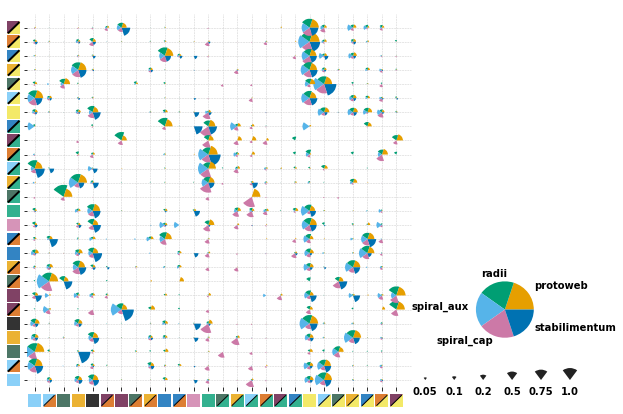

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7), facecolor='w')

SIZE_MULTIPLIER = 0.85

patches = []
lbl = []
for ist, st in enumerate(list(mtxTransByStage.keys())):
    for i in range(mtxTransByStage[st].shape[0]):
        for j in range(mtxTransByStage[st].shape[1]):
            if mtxTransByStage[st][i, j] >= 0:
                w = Wedge((j, i), SIZE_MULTIPLIER * np.sqrt(mtxTransByStage[st][i,j]), 
                          ist * 360/ len(mtxTransByStage), 
                          (ist+1) * 360 / len(mtxTransByStage),
                          facecolor=COLORS_STAGES[st], label=st if not st in lbl else None,
                          zorder=-10 * mtxTransByStage[st][i,j])
                if not st in lbl:
                    lbl.append(st)
                    patches.append(w)
                ax.add_artist(w)

w = mtxTransByStage[st].shape[0]
for i in range(w):
    ax.plot([-1, w], [i, i], color='#cccccc', linestyle='--', zorder=-100, linewidth=0.5)
    ax.plot([i, i], [-1, w], color='#cccccc', linestyle='--', zorder=-100, linewidth=0.5)
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels([''.format(xi) for xi, x in enumerate(labels)])
ax.set_yticklabels([''.format(xi) for xi, x in enumerate(labels)])

w = 0.9
for k in range(len(labels)):
    if '/' not in labels[k]:
        ax.add_artist(Polygon([[k + w/2, -1], [k + w/2, -(1+w)], [k - w/2, -(1+w)], [k - w/2, -1]], 
                              clip_on=False, facecolor=COLORS_CLUSTERS[labels[k]]))
    else:
        c1 = COLORS_CLUSTERS[labels[k][:labels[k].find('/')]]
        c2 = COLORS_CLUSTERS[labels[k][(labels[k].find('/')+1):]]
        ax.add_artist(Polygon([[k + w/2, -1],[k + w/2, -(1+w)], [k - w/2, -(1+w)]], 
                              clip_on=False, facecolor=c1, edgecolor=None))
        ax.add_artist(Polygon([[k + w/2, -1],[k - w/2 ,-1], [k - w/2, -(1+w)]], 
                              clip_on=False, facecolor=c2, edgecolor=None))
        ax.plot([k-w/2+0.1, k+w/2-0.1], [-(1+w)+0.1, -1-0.1], color='black', 
                linewidth=1, zorder=100, clip_on=False)
    
for k in range(len(labels)):
    if '/' not in labels[k]:
        ax.add_artist(Polygon([[-1, k + w/2], [-(1+w), k + w/2], [-(1+w), k - w/2], [-1, k - w/2]], 
                              clip_on=False, facecolor=COLORS_CLUSTERS[labels[k]]))
    else:
        c1 = COLORS_CLUSTERS[labels[k][:labels[k].find('/')]]
        c2 = COLORS_CLUSTERS[labels[k][(labels[k].find('/')+1):]]
        ax.add_artist(Polygon([[-1, k + w/2],[-(1+w), k + w/2], [-(1+w), k - w/2]], 
                              clip_on=False, facecolor=c2, edgecolor=None))
        ax.add_artist(Polygon([[-1, k + w/2],[-1, k - w/2], [-(1+w), k - w/2]], 
                              clip_on=False, facecolor=c1, edgecolor=None))
        ax.plot([-(1+w)+0.1, -1-0.1], [k-w/2+0.1, k+w/2-0.1], color='black', 
                linewidth=2, zorder=100, clip_on=False)

ax.set_xlim(-0.5, len(labels)+ 0.5)
ax.set_ylim(-0.5, len(labels)+ 0.5)

# Size legend
for p, prob in enumerate([0.05, 0.10, 0.20, 0.5, 0.75, 1.0]):
    w = Wedge((p * 2.0 + 27, 0), np.sqrt(prob) * SIZE_MULTIPLIER,
              90 - 0.5 * 360 / len(mtxTransByStage),
              90 + 0.5 * 360 / len(mtxTransByStage),
              facecolor='#222222', clip_on=False)
    ax.add_artist(w)
    ax.text(p * 2.0 + 27, -1, prob, horizontalalignment='center')
    
# Color legend
for ist, st in enumerate(list(mtxTransByStage.keys())):
    w = Wedge((32.5, 5), 2,
              ist * 360/ len(mtxTransByStage),
              (ist+1) * 360 / len(mtxTransByStage),
              facecolor=COLORS_STAGES[st], clip_on=False)
    ax.add_artist(w)
    ax.text(
        32.5 + np.cos((0.5 + ist) * 2 * np.pi / len(mtxTransByStage)) * 2.5,
        5  + np.sin((0.5 + ist) * 2 * np.pi / len(mtxTransByStage)) * 2.5,
        st, horizontalalignment=['left', 'center', 'right', 'right', 'left'][ist])

fig.savefig('C:/Users/acorver/Desktop/paper-figures/Fig_4c.pdf', dpi=600, bbox_inches='tight')